# **BERT As Feature Extractor for Text Classification Task (CoLA)**

In [0]:
!unzip '/content/drive/My Drive/GLUE/cola_public_1.1.zip'

Archive:  /content/drive/My Drive/GLUE/cola_public_1.1.zip
replace cola_public/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [142]:
!pip install transformers
!pip install pytorch-ignite

     |████████████████████████████████| 112kB 2.8MB/s 


In [25]:
import pandas as pd

train = pd.read_csv('/content/cola_public/raw/in_domain_train.tsv', sep ='\t', header = None)
dev = pd.read_csv('/content/cola_public/raw/in_domain_train.tsv', sep ='\t', header = None)
test = pd.read_csv('/content/cola_public/raw/out_of_domain_dev.tsv', sep = '\t', header = None)

train.head()

,0,1,2,3
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [0]:
train_df = train[[1, 3]].copy()
train_df = train_df.rename(columns = {1:'label', 3:"comment"})

dev_df = dev[[1,3]].copy()
dev_df = dev_df.rename(columns ={1: 'label', 3:'comment'})

In [0]:
train_df['length'] = train_df['comment'].apply(lambda x: len(x.split(' ')))

In [34]:
train_df.head()

,label,comment,length
0,1,"Our friends won't buy this analysis, let alone...",13
1,1,One more pseudo generalization and I'm giving up.,8
2,1,One more pseudo generalization or I'm giving up.,8
3,1,"The more we study verbs, the crazier they get.",9
4,1,Day by day the facts are getting murkier.,8


In [36]:
print(f"Maximum number of words in a comment: {max(train_df['length'])}")
print()
print(f"Minimum number of words in a comment: {min(train_df['length'])}")

Maximum number of words in a comment: 42

Minimum number of words in a comment: 2


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Number of words')]

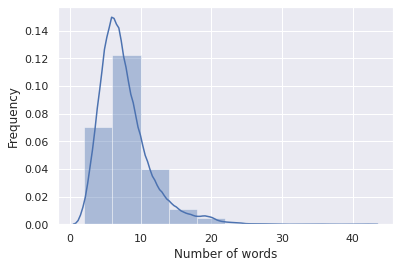

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

ax = sns.distplot(train_df['length'].values, bins = 10)
ax.set(xlabel = 'Number of words', ylabel = 'Frequency')

In [41]:
positive = len(train_df[train_df['label']==1])
neutral = len(train_df) - positive

print(f'Total number of comments in the train dataset is: {len(train_df)}')
print()
print(f"Number of positive comments is: {positive}")
print()
print(f"Positive comments accoutn for {positive/len(train_df):.2f} fraction of the dataset")

Total number of comments in the train dataset is: 8551

Number of positive comments is: 6023

Positive comments accoutn for 0.70 fraction of the dataset


"One more pseudo generalization and I'm giving up."

# We have imbalanced dataset, and there are a couple of methods dealing with imbalanced set:
1. Weighted Loss (this_notebook)
2. Over/Under Sampling

In [46]:
from transformers import BertConfig, BertTokenizer, BertModel
config = BertConfig.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
ft_extractor = BertModel.from_pretrained('bert-base-uncased')

In [0]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
## Create a dataset
class CoLa(Dataset):
    def __init__(self, df, tokenizer, max_length = 64):

        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        
        return len(self.df)

    def __getitem__(self, idx):

        comment = self.df['comment'][idx]
        label = self.df['label'][idx]

        en_cmt = tokenizer.encode_plus(comment, 
                                       add_special_tokens = True, ## adding [CLS] and [SEP] at the beginning and ending of each tokens
                             
                                       max_length = self.max_length, 
                                       pad_to_max_length = True, ## pad [PAD] tokens to reach maxlength
                                       return_token_type_ids = False,
                                       return_attention_mask = True,
                                       return_tensor = 'pt'## return output as pytorch tensor 
                                       )
        input_ids = np.array(en_cmt['input_ids'])
        attention_mask = np.array(en_cmt['attention_mask'])

        input_ids = torch.from_numpy(input_ids)
        attention_mask = torch.from_numpy(attention_mask)

        label = torch.full((1,1),label)

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'label': label}

In [68]:
##Load train and dev set
train_dataset = CoLa(train_df, tokenizer, max_length = 64)
dev_dataset = CoLa(dev_df, tokenizer, max_length = 64)
 ## get an example
train_dataset.__getitem__(10)

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([ 101, 1996, 4401, 4191, 1996, 2377, 2125, 1996, 2754, 1012,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 'label': tensor([[1.]])}

In [0]:
## Define hyperparameters
from collections import namedtuple

AdaptationConfig = namedtuple('AdaptationConfig', 
    field_names = "num_classes, dropout, initializer_range, batch_size, lr, max_norm, n_epochs,"
                    "n_warmup, valid_set_prop, gradient_accumulation_steps, device,"
                    "log_dir, dataset_cache")

adapt_args = AdaptationConfig(
                    2,            0.1,         0.02,           16,    6.5e-5,   1.0,      3,
                    10,             0.1,        1, "cuda" if torch.cuda.is_available() else "cpu",
                    "./",       "./dataset_cache.bin")

In [73]:
## Dataloader for training
train_loader =  DataLoader(train_dataset, batch_size = adapt_args.batch_size, num_workers = 1)
dev_loader = DataLoader(dev_dataset, batch_size = adapt_args.batch_size, num_workers = 1)

## Sampling a batch, Expect return input_ids of shape (batch_size, max_length)
sample_batch = next(iter(train_loader))

print(f"Shape of one training batch: {sample_batch['input_ids'].shape}")

Shape of one training batch: torch.Size([16, 64])


In [0]:
## Model
from torch import nn
class BertExtractor(nn.Module):
    def __init__(self, pretrained_model, num_classes, adapt_config, pretrained_config):
        super().__init__()
        
        self.pretrained_model = pretrained_model

        ## as we only use bert as feature extractor, we dont back propagate through pretrained models
        for parameters in self.pretrained_model.parameters():
            parameters.requires_grad == False

        self.num_classes = num_classes
        self.adapt_config = adapt_config
        self.pretrained_config = pretrained_config

        self.classifier_head = nn.Linear(self.pretrained_config.hidden_size, self.num_classes)
        self.apply(self.init_weight)

    def init_weight(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, input_ids, attention_mask):

        last_hidden_state, cls_state = self.pretrained_model(input_ids,
                                                             attention_mask = attention_mask,
                                                             token_type_ids = None)
        
        logits = self.classifier_head(cls_state)


        ##set hard labels with threshold

        prob = torch.sigmoid(logits)
        
        threshold = 0.5
        ones = torch.ones((prob.shape)).to(adapt_args.device)
        zeros = torch.zeros((logits.shape)).to(adapt_args.device)

        hard_label = torch.where(prob > threshold, ones, zeros)
        return logits, hard_label




In [0]:
### create models
model = BertExtractor(ft_extractor, num_classes = 1, adapt_config = adapt_args, pretrained_config = config)
model = model.to(adapt_args.device)

In [129]:
## pass one forward pass
batch = next(iter(train_loader))
logits, labels = model(input_ids = batch['input_ids'].to(adapt_args.device), 
                        attention_mask = batch['attention_mask'].to(adapt_args.device))

print(f"Output shape: {logits.shape}")

Output shape: torch.Size([16, 1])


In [147]:
batch['label'].squeeze(1).shape

torch.Size([16, 1])

In [0]:
## Set weight for positive class
pos_w  = torch.from_numpy(np.array([0.3/0.7])).to(adapt_args.device)

In [0]:
from torch import optim
from torch.nn import BCEWithLogitsLoss

criterion = BCEWithLogitsLoss(pos_weight = pos_w)
optimizer = optim.AdamW(model.parameters(), lr = adapt_args.lr)

In [0]:
import os
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage, Accuracy
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import CosineAnnealingScheduler, PiecewiseLinear, create_lr_scheduler_with_warmup, ProgressBar


In [1]:
# Define training function
def update(engine, batch):
    model.train()

    ids = batch['input_ids'].to(adapt_args.device)
    mask = batch['attention_mask'].to(adapt_args.device)
    labels = batch['label'].to(adapt_args.device).squeeze(1)

    logits, _  = model(input_ids = ids, attention_mask = mask)

    loss = criterion(logits, labels)
    loss = loss / adapt_args.gradient_accumulation_steps
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), adapt_args.max_norm)

    if engine.state.iteration % adapt_args.gradient_accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()
trainer = Engine(update)

NameError: ignored

In [0]:
# Evaluation function and evaluator (evaluator output is the input of the metrics)
def inference(engine, batch):
    model.eval()
    with torch.no_grad():
        ids = batch['input_ids'].to(adapt_args.device)
        mask = batch['attention_mask'].to(adapt_args.device)
        labels = batch['label'].to(adapt_args.device).squeeze(1)
        
        logits, output = model(input_ids = ids, attention_mask = mask)
    return output, labels
evaluator = Engine(inference)

In [172]:
# Attache metric to evaluator & evaluation to trainer: evaluate on valid set after each epoch
Accuracy().attach(evaluator, "accuracy")
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(dev_loader)
    print(f"Validation Epoch: {engine.state.epoch} Error rate: {100*(1 - evaluator.state.metrics['accuracy'])}")


# Learning rate schedule: linearly warm-up to lr and then to zero
scheduler = PiecewiseLinear(optimizer, 'lr', [(0, 0.0), (adapt_args.n_warmup, adapt_args.lr),
                                              (len(train_loader)*adapt_args.n_epochs, 0.0)])
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)

# Add progressbar with loss
RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")
ProgressBar(persist=True).attach(trainer, metric_names=['loss'])

# Save checkpoints and finetuning config
checkpoint_handler = ModelCheckpoint(adapt_args.log_dir, 'finetuning_checkpoint', save_interval=1, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoint_handler, {'mymodel': model})
torch.save(adapt_args, os.path.join(adapt_args.log_dir, 'fine_tuning_args.bin'))

/usr/local/lib/python3.6/dist-packages/ignite/handlers/checkpoint.py:369: UserWarning: Argument save_interval is deprecated and should be None. Please, use events filtering instead, e.g. Events.ITERATION_STARTED(every=1000)
  warnings.warn(msg)


In [174]:
trainer.run(train_loader, max_epochs=adapt_args.n_epochs)

Engine run is terminating due to exception: name 'valid_loader' is not defined.


NameError: ignored

In [169]:
evaluator.run(dev_loader)
print(f"Test Results - Error rate: {100*(1.00 - evaluator.state.metrics['accuracy']):.3f}")

Test Results - Error rate: 29.564
